In [20]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import numpy as np

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

# Download the Music Dataset from : https://github.com/mdeff/fma

In [21]:
from pathlib import Path

data_dir = Path("fma/data")

if not data_dir.exists():
    os.makedirs(data_dir)
    !curl -L https://os.unil.cloud.switch.ch/fma/fma_small.zip -o fma_small.zip
    !unzip -q fma_small.zip -d fma/data/
    !curl -L https://os.unil.cloud.switch.ch/fma/fma_metadata.zip -o fma_metadata.zip
    !unzip -q fma_metadata.zip -d fma/data/
    !rm fma_small.zip fma_metadata.zip
else:
    print("Dataset already present, skipping download.")

Dataset already present, skipping download.


# Step 1 : Preprocessing

## Let's create the Dataframe df (track_id/genre/filepath)

In [22]:
META_PATH = 'fma/data/fma_metadata/'

In [23]:
tracks = pd.read_csv(META_PATH + 'tracks.csv')
display(tracks.head())

/var/folders/wq/w5wc4my53t1fl3m0js49n6v40000gn/T/ipykernel_55106/1169983381.py:1: DtypeWarning: Columns (0,1,5,6,8,12,18,20,21,22,24,33,34,38,39,44,47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  tracks = pd.read_csv(META_PATH + 'tracks.csv')


,Unnamed: 0,album,album.1,album.2,album.3,album.4,album.5,album.6,album.7,album.8,...,track.10,track.11,track.12,track.13,track.14,track.15,track.16,track.17,track.18,track.19
0,NaN,comments,date_created,date_released,engineer,favorites,id,information,listens,producer,...,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
1,track_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
3,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
4,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World


In [24]:
# Tracks has two levels !

tracks = pd.read_csv(
    META_PATH + 'tracks.csv',
    index_col=0,      # "Unnamed: 0" becomes index (= track_id)
    header=[0, 1]     # use first TWO rows as a multi-level column header
)

In [25]:
display(tracks)

album                                                     \
         comments         date_created        date_released engineer   
track_id                                                               
2               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
3               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
5               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
10              0  2008-11-26 01:45:08  2008-02-06 00:00:00      NaN   
20              0  2008-11-26 01:45:05  2009-01-06 00:00:00      NaN   
...           ...                  ...                  ...      ...   
155316          0  2017-03-30 15:20:35  2017-02-17 00:00:00      NaN   
155317          0  2017-03-30 15:20:35  2017-02-17 00:00:00      NaN   
155318          0  2017-03-30 15:20:35  2017-02-17 00:00:00      NaN   
155319          0  2017-03-30 15:20:35  2017-02-17 00:00:00      NaN   
155320          0  2017-03-26 16:22:18  2017-03-26 00:00:00      NaN   

                                                                              \
         favorites     id                                        information   
track_id                                                                       
2                4      1                                            <p></p>   
3                4      1                                            <p></p>   
5                4      1                                            <p></p>   
10               4      6                                                NaN   
20               2      4          <p> "spiritual songs" from Nicky Cook</p>   
...            ...    ...                                                ...   
155316           0  22940  <p>A live performance at Monty Hall on Feb 17,...   
155317           0  22940  <p>A live performance at Monty Hall on Feb 17,...   
155318           0  22940  <p>A live performance at Monty Hall on Feb 17,...   
155319           0  22940  <p>A live performance at Monty Hall on Feb 17,...   
155320           1  22906                                                NaN   

                               \
         listens     producer   
track_id                        
2           6073          NaN   
3           6073          NaN   
5           6073          NaN   
10         47632          NaN   
20          2710          NaN   
...          ...          ...   
155316      1506  Monty Hall    
155317      1506  Monty Hall    
155318      1506  Monty Hall    
155319      1506  Monty Hall    
155320      7481          NaN   

                                                             ...       track  \
                                                       tags  ... information   
track_id                                                     ...               
2                                                        []  ...         NaN   
3                                                        []  ...         NaN   
5                                                        []  ...         NaN   
10                                                       []  ...         NaN   
20                                                       []  ...         NaN   
...                                                     ...  ...         ...   
155316                                                   []  ...         NaN   
155317                                                   []  ...         NaN   
155318                                                   []  ...         NaN   
155319                                                   []  ...         NaN   
155320    ['ballad', 'epic', 'rockabilly', 'curse', 'hex...  ...         NaN   

                                 \
         interest language_code   
track_id                          
2            4656            en   
3            1470            en   
5            1933            en   
10          54881            en   
20            978            en   
...           ... 

In [26]:
print(tracks.columns)
print(tracks.columns.levels)

MultiIndex([( 'album',          'comments'),
            ( 'album',      'date_created'),
            ( 'album',     'date_released'),
            ( 'album',          'engineer'),
            ( 'album',         'favorites'),
            ( 'album',                'id'),
            ( 'album',       'information'),
            ( 'album',           'listens'),
            ( 'album',          'producer'),
            ( 'album',              'tags'),
            ( 'album',             'title'),
            ( 'album',            'tracks'),
            ( 'album',              'type'),
            ('artist', 'active_year_begin'),
            ('artist',   'active_year_end'),
            ('artist', 'associated_labels'),
            ('artist',               'bio'),
            ('artist',          'comments'),
            ('artist',      'date_created'),
            ('artist',         'favorites'),
            ('artist',                'id'),
            ('artist',          'latitude'),
          

In [27]:
display(tracks['track'].head())

,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,genres_all,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
track_id,,,,,,,,,,,,,,,,,,,,
2,256000,0,NaN,2008-11-26 01:48:12,2008-11-26 00:00:00,168,2,Hip-Hop,[21],[21],NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
3,256000,0,NaN,2008-11-26 01:48:14,2008-11-26 00:00:00,237,1,Hip-Hop,[21],[21],NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
5,256000,0,NaN,2008-11-26 01:48:20,2008-11-26 00:00:00,206,6,Hip-Hop,[21],[21],NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
10,192000,0,Kurt Vile,2008-11-25 17:49:06,2008-11-26 00:00:00,161,178,Pop,[10],[10],NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
20,256000,0,NaN,2008-11-26 01:48:56,2008-01-01 00:00:00,311,0,NaN,"[76, 103]","[17, 10, 76, 103]",NaN,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,NaN,3,NaN,[],Spiritual Level


In [28]:
df = tracks['track'][['genre_top', 'genres', 'genres_all']]
display(df)

,genre_top,genres,genres_all
track_id,,,
2,Hip-Hop,[21],[21]
3,Hip-Hop,[21],[21]
5,Hip-Hop,[21],[21]
10,Pop,[10],[10]
20,NaN,"[76, 103]","[17, 10, 76, 103]"
...,...,...,...
155316,Rock,[25],"[25, 12]"
155317,Rock,[25],"[25, 12]"
155318,Rock,[25],"[25, 12]"


In [29]:
print((df['genre_top'].isna()).value_counts())

# Around 50% of the tracks have more than one genre.

genre_top
True     56976
False    49598
Name: count, dtype: int64


In [30]:
for column in pd.unique(df['genre_top']) :
  print(column)
print("Number of unique genre :", len(pd.unique(df['genre_top'])) - 1)

Hip-Hop
Pop
nan
Rock
Experimental
Folk
Jazz
Electronic
Spoken
International
Soul-RnB
Blues
Country
Classical
Old-Time / Historic
Instrumental
Easy Listening
Number of unique genre : 16


In [31]:
df = df.dropna(subset=['genre_top'])

for i in range(len(df)):
  dict[df['genre_top'].iloc[i]]

df = df.drop(columns=['genres', 'genres_all'])

display(df)

# We only select the tracks that have a top genre.
# We selected 49.598k tracks.
# There are 16 unique genres.

,genre_top
track_id,
2,Hip-Hop
3,Hip-Hop
5,Hip-Hop
10,Pop
134,Hip-Hop
...,...
155315,Rock
155316,Rock
155317,Rock


In [32]:
df['genre_top'].value_counts()

genre_top
Rock                   14182
Experimental           10608
Electronic              9372
Hip-Hop                 3552
Folk                    2803
Pop                     2332
Instrumental            2079
International           1389
Classical               1230
Jazz                     571
Old-Time / Historic      554
Spoken                   423
Country                  194
Soul-RnB                 175
Blues                    110
Easy Listening            24
Name: count, dtype: int64

In [33]:
AUDIO_PATH = 'fma/data/fma_small/'

def get_audio_path(t_id, Audio_Path):
  return Audio_Path + f'{t_id:06d}'[0:3] + '/' + f'{t_id:06d}' + '.mp3'

print(get_audio_path(2, AUDIO_PATH))

fma/data/fma_small/000/000002.mp3


In [34]:
df['file_path'] = df.index.map(lambda x: get_audio_path(x, AUDIO_PATH))

display(df)

,genre_top,file_path
track_id,,
2,Hip-Hop,fma/data/fma_small/000/000002.mp3
3,Hip-Hop,fma/data/fma_small/000/000003.mp3
5,Hip-Hop,fma/data/fma_small/000/000005.mp3
10,Pop,fma/data/fma_small/000/000010.mp3
134,Hip-Hop,fma/data/fma_small/000/000134.mp3
...,...,...
155315,Rock,fma/data/fma_small/155/155315.mp3
155316,Rock,fma/data/fma_small/155/155316.mp3
155317,Rock,fma/data/fma_small/155/155317.mp3


In [35]:
os.path.exists(AUDIO_PATH + '/155/155319')

# Some tracks are not in the small dataset

False

In [36]:
df = df[df['file_path'].map(lambda x: os.path.exists(x))] # Select only the tracks that are in the fma_small dataset

display(df)

,genre_top,file_path
track_id,,
2,Hip-Hop,fma/data/fma_small/000/000002.mp3
5,Hip-Hop,fma/data/fma_small/000/000005.mp3
10,Pop,fma/data/fma_small/000/000010.mp3
140,Folk,fma/data/fma_small/000/000140.mp3
141,Folk,fma/data/fma_small/000/000141.mp3
...,...,...
154308,Hip-Hop,fma/data/fma_small/154/154308.mp3
154309,Hip-Hop,fma/data/fma_small/154/154309.mp3
154413,Pop,fma/data/fma_small/154/154413.mp3


In [37]:
# Detect corrupted files from the dataset by trying to load them and checking if an error is raised
# If so remove the corresponding row from df

'''
corrupted_files = []
corrupted_track_ids = []

for track_id, row in df.iterrows():
    file_path = row['file_path']
    try:
        # Attempt to load the audio file
        librosa.load(file_path, sr=None)
    except Exception as e:
        # If an exception occurs, record the track_id and file_path
        corrupted_files.append({
            'track_id': track_id,
            'file_path': file_path,
            'error': str(e)
        })
        corrupted_track_ids.append(track_id)

# Remove corrupted files from the DataFrame
df = df.drop(index=corrupted_track_ids)

print(f"Found {len(corrupted_files)} corrupted files.")
if corrupted_files:
    print("Details of corrupted files:")
    for item in corrupted_files:
        print(item)

display(df)
'''

'\ncorrupted_files = []\ncorrupted_track_ids = []\n\nfor track_id, row in df.iterrows():\n    file_path = row[\'file_path\']\n    try:\n        # Attempt to load the audio file\n        librosa.load(file_path, sr=None)\n    except Exception as e:\n        # If an exception occurs, record the track_id and file_path\n        corrupted_files.append({\n            \'track_id\': track_id,\n            \'file_path\': file_path,\n            \'error\': str(e)\n        })\n        corrupted_track_ids.append(track_id)\n\n# Remove corrupted files from the DataFrame\ndf = df.drop(index=corrupted_track_ids)\n\nprint(f"Found {len(corrupted_files)} corrupted files.")\nif corrupted_files:\n    print("Details of corrupted files:")\n    for item in corrupted_files:\n        print(item)\n\ndisplay(df)\n'

In [38]:
corrupted_track_ids = [99134, 108925, 133297]

for c_idx in corrupted_track_ids:
  print(c_idx)
  df = df.drop(index=c_idx)

display(df)

99134
108925
133297


,genre_top,file_path
track_id,,
2,Hip-Hop,fma/data/fma_small/000/000002.mp3
5,Hip-Hop,fma/data/fma_small/000/000005.mp3
10,Pop,fma/data/fma_small/000/000010.mp3
140,Folk,fma/data/fma_small/000/000140.mp3
141,Folk,fma/data/fma_small/000/000141.mp3
...,...,...
154308,Hip-Hop,fma/data/fma_small/154/154308.mp3
154309,Hip-Hop,fma/data/fma_small/154/154309.mp3
154413,Pop,fma/data/fma_small/154/154413.mp3


In [39]:
display(df['genre_top'].value_counts())

# The dataset is composed of 8 genres!

genre_top
Hip-Hop          1000
Pop              1000
Folk             1000
International    1000
Instrumental     1000
Experimental      999
Rock              999
Electronic        999
Name: count, dtype: int64

In [40]:
# Create a Class (int) feature

i = 0
dict={}
for column in df['genre_top'].unique():
  dict[column] = i
  dict[i] = column
  i += 1

print(dict)

df['class'] = df['genre_top'].map(dict)

display(df)

{'Hip-Hop': 0, 0: 'Hip-Hop', 'Pop': 1, 1: 'Pop', 'Folk': 2, 2: 'Folk', 'Experimental': 3, 3: 'Experimental', 'Rock': 4, 4: 'Rock', 'International': 5, 5: 'International', 'Electronic': 6, 6: 'Electronic', 'Instrumental': 7, 7: 'Instrumental'}


,genre_top,file_path,class
track_id,,,
2,Hip-Hop,fma/data/fma_small/000/000002.mp3,0
5,Hip-Hop,fma/data/fma_small/000/000005.mp3,0
10,Pop,fma/data/fma_small/000/000010.mp3,1
140,Folk,fma/data/fma_small/000/000140.mp3,2
141,Folk,fma/data/fma_small/000/000141.mp3,2
...,...,...,...
154308,Hip-Hop,fma/data/fma_small/154/154308.mp3,0
154309,Hip-Hop,fma/data/fma_small/154/154309.mp3,0
154413,Pop,fma/data/fma_small/154/154413.mp3,1


## Mel-Spectrogram visualization

In [41]:
x, sr = librosa.load('fma/data/fma_small/000/000002.mp3', sr=None)
# Librosa.load returns the audio np.array time series and the sampling rate
# sr=None keeps the sampling rate of the original audio
print('shape of x:', x.shape)
print('sampling rate:', sr, 'Hz')
print('time duration: %.2f s' % (len(x)/sr))
#The audio is 30 sec long

shape of x: (1321967,)
sampling rate: 44100 Hz
time duration: 29.98 s


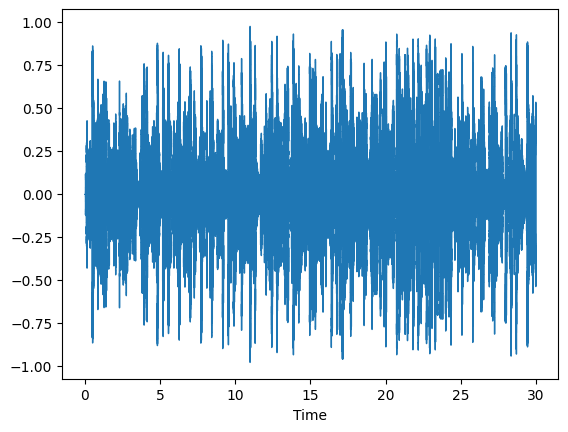

In [42]:
librosa.display.waveshow(x, sr=sr)

In [43]:
mel = librosa.feature.melspectrogram(y=x, sr=sr,
                                     n_fft=2048,
                                     hop_length=512,
                                     n_mels=128,
                                     power=2.0)
                                     # (default mel parameters)
                                     # n_mels is the number of vertical bands
print(mel.shape)
print(mel.dtype)

(128, 2582)
float32


mel_db shape: (128, 2582)
[[-80.       -80.       -56.291958 ... -26.588568 -25.919014 -23.309195]
 [-80.       -74.67524  -58.71792  ... -17.651487 -19.243626 -21.871899]
 [-80.       -62.929474 -53.352894 ... -22.546886 -22.10431  -22.779448]
 ...
 [-80.       -80.       -80.       ... -80.       -80.       -80.      ]
 [-80.       -80.       -80.       ... -80.       -80.       -80.      ]
 [-80.       -80.       -80.       ... -80.       -80.       -80.      ]]


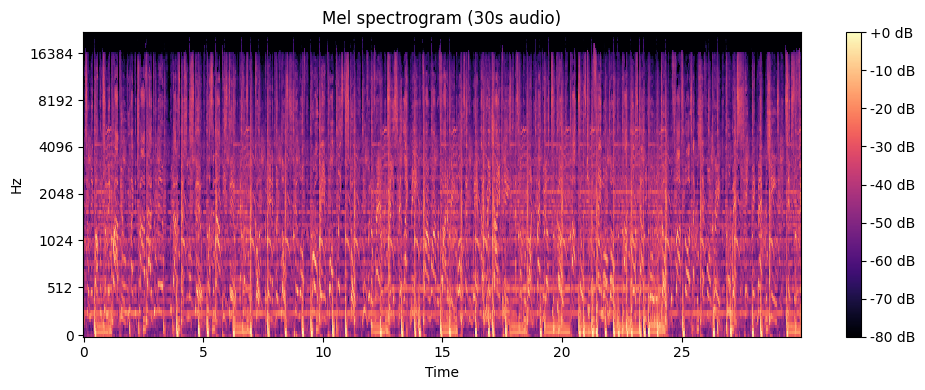

In [44]:
mel_db = librosa.power_to_db(mel, ref=np.max)
# dB Representation is closer to human earing
# ref puts the maximum value to 0dB
print("mel_db shape:", mel_db.shape)
print(mel_db)

plt.figure(figsize=(10, 4))
librosa.display.specshow(
    mel_db,
    sr=sr,
    hop_length=512,
    x_axis='time',
    y_axis='mel'
)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram (30s audio)')
plt.tight_layout()
plt.show()

-4.7277425e-08
1.0
(128, 2582)


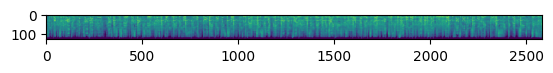

In [45]:
x = (mel_db - mel_db.mean()) / (mel_db.std() + 1e-8) # Normalize the 2d greyscale image (over every pixels)
print(x.mean())
print(x.std())
print(x.shape)
plt.imshow(x)

# Step 2 : Pytorch Dataset and Dataloader

## Create the mels directory and save the mels.npy to avoid computing mels during training

In [46]:
def get_melspectrogram(file_path, duration=3, sr=44100, n_fft=2048, hop_length=512, n_mels=128):

    x , _ = librosa.load(file_path, sr=sr)
    dist = duration * sr - len(x)
    target_length = sr * duration

    if dist >= 0 : # Padding is needed because x is shorter than 3sec
      x_pad = np.pad(x, (0, dist), 'constant')
    else :         # x is longer than 3sec so it needs to be shorten
      i = np.random.randint(0, len(x) - target_length)
      x_pad = x[i:i+target_length]

    mel = librosa.feature.melspectrogram(y=x_pad, sr=sr, n_fft=n_fft,
                                        hop_length=hop_length, n_mels=n_mels, power=2)
    mel_db = librosa.power_to_db(mel).astype(np.float32)

    mel_db_norm = ( mel_db - mel_db.mean() ) / (mel_db.std() + 1e-8)

    return mel_db_norm

In [48]:
# Compute and save the normalized dB-melspectrograms
MEL_DIR = 'mels'

if not os.path.exists(MEL_DIR):
  os.mkdir(MEL_DIR)
  i=0
  for track_id, row in df.iterrows():
    i+=1
    file_path = row['file_path']
    output_path = f'{MEL_DIR}/{track_id}.npy'

    if os.path.exists(output_path):
      continue

    mel_db_norm = get_melspectrogram(file_path,
                                    duration=3,                                # 3 seconds crop
                                    sr=44100,                                  # Keep the sampling rate consistant
                                    n_fft=2048, hop_length=512, n_mels=128)    # Basic melspctrogram setting

    np.save(output_path, mel_db_norm)

    if i % 500 ==0:
      print(f'Saved {i} melspectrograms')

  # Should take 20 minutes to compute

  print(f'Saving of {i} melspectrograms in {MEL_DIR} finished!')

else :
  print('mels directory already exists')

[src/libmpg123/layer3.c:INT123_do_layer3():1844] error: dequantization failed!


Saved 500 melspectrograms


[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!


Saved 1000 melspectrograms


[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!


Saved 1500 melspectrograms
Saved 2000 melspectrograms


[src/libmpg123/layer3.c:INT123_do_layer3():1776] error: part2_3_length (3360) too large for available bit count (3240)
[src/libmpg123/layer3.c:INT123_do_layer3():1776] error: part2_3_length (3328) too large for available bit count (3240)


Saved 2500 melspectrograms
Saved 3000 melspectrograms
Saved 3500 melspectrograms
Saved 4000 melspectrograms


Note: Illegal Audio-MPEG-Header 0x00000000 at offset 33361.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
/var/folders/wq/w5wc4my53t1fl3m0js49n6v40000gn/T/ipykernel_55106/2449162960.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  x , _ = librosa.load(file_path, sr=sr)
/Users/colinminini/Desktop/SCOC_ICE/Apprentissage Profond/.venv/lib/python3.13/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Note: Illegal Audio-MPEG-Header 0x00000000 at offset 22401.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not 

Saved 4500 melspectrograms
Saved 5000 melspectrograms
Saved 5500 melspectrograms
Saved 6000 melspectrograms
Saved 6500 melspectrograms
Saved 7000 melspectrograms
Saved 7500 melspectrograms
Saving of 7997 melspectrograms in mels finished!


## Pytorch Dataset

In [49]:
class Audio_Classification_Dataset(Dataset):

    def __init__(self, df=df, MEL_DIR=MEL_DIR):
      self.df = df
      self.MEL_DIR = MEL_DIR

    def __len__(self):
      return len(self.df)

    def __getitem__(self, idx):

      track_id = self.df.index[idx]
      mel_db_norm = np.load(f'{self.MEL_DIR}/{track_id}.npy')
      x_tensor = torch.from_numpy(mel_db_norm).unsqueeze(0) # Size (1, n_mels, time)
      label = int(self.df.iloc[idx]['class'])

      return x_tensor, label  # label is an int between 0 and num_classes (here 7)
                              # Input size is always the same : (1, n_mels=128, time)
                              # with time being constant (we padded the audios)

# Step 3 : Design the Deep Learning Model

In [50]:
class CNN(nn.Module):

    def __init__(self, num_classes=8,                                               # Number of genres
                 sr=44100, duration=3, mel_bins=128, hop_length=512,                # Audio settings
                 channel_size=16, kernel_size=3, num_conv_layers=4, p_dropout=0.2): # CNN settings

      super().__init__()

      self.sr = sr
      self.hop_length = hop_length
      self.duration = duration
      self.time = int(self.sr * self.duration / self.hop_length)
      self.mel_bins = mel_bins
      self.num_classes = num_classes

      self.channel_size = channel_size
      self.kernel_size = kernel_size
      self.num_conv_layers = num_conv_layers
      self.p_dropout= p_dropout

      self.layers = [
          nn.Conv2d(1, self.channel_size, kernel_size=self.kernel_size, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),
          nn.Dropout(self.p_dropout)
      ]

      for i in range(1, self.num_conv_layers):
        self.layers += [
            nn.Conv2d(self.channel_size * (2**(i-1)), self.channel_size * (2**i), kernel_size=self.kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(self.p_dropout)
        ]

      self.ConvLayers = nn.Sequential(*self.layers)

      final_channels = self.channel_size * (2**(self.num_conv_layers-1))
      final_mel_bins = self.mel_bins // (2**self.num_conv_layers)
      final_time = self.time // (2**self.num_conv_layers)

      self.Classifier_Logits = nn.Sequential(
          nn.Linear(final_channels * final_mel_bins * final_time, 128),
          nn.ReLU(),
          nn.Linear(128,self.num_classes)
      )

    def forward(self, x): # x.shape : (B, 1, n_mels=128, time=258)
      bs = x.size(0)

      x = self.ConvLayers(x) # (B, final_channels, final_mel_bins, final_time)

      x_flatten = x.view(bs, -1) # x is flatten

      logits = self.Classifier_Logits(x_flatten)

      return logits

# Step 4 : Trainer class

## Train and test functions

In [51]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):

    model.train()
    epoch_losses = []
    epoch_accuracies = []
    batch_num = 0
    for x, y in train_loader:

      x, y = x.to(device), y.to(device)
      optimizer.zero_grad()
      logits = model(x)               # (B, C)
      loss = criterion(logits, y)     # criterion must take logits as input (e.g nn.CrossEntropyLoss())
                                      # reduction = 'mean' by default so the loss is averaged over the batch
      loss.backward()
      optimizer.step()

      preds = torch.argmax(logits, dim=-1)
      accuracy = (preds == y).sum().item() / x.size(0)
      epoch_losses.append(loss.item())
      epoch_accuracies.append(accuracy)

      batch_num += 1

      #if batch_num % 100 == 0 or batch_num == 1 or batch_num == len(train_loader):
      #  print(f'batch number {batch_num}, loss batch: {loss.item():.4f}, accuracy batch: {accuracy:.2f}')

    return sum(epoch_losses) / len(epoch_losses), sum(epoch_accuracies) / len(epoch_accuracies)

In [52]:
@torch.no_grad()
def testing_one_epoch(model, test_loader, criterion, device, epoch_idx=0):
    model.eval()
    total_loss, total_correct, total_samples = 0.0, 0, 0

    for x, y in test_loader:
        x, y = x.to(device), y.to(device)

        logits = model(x)
        loss = criterion(logits, y)

        bs = y.size(0)
        total_loss += loss.item() * bs
        total_correct += (logits.argmax(dim=1) == y).sum().item()
        total_samples += bs

    epoch_loss = total_loss / total_samples
    epoch_acc = total_correct / total_samples
    return epoch_loss, epoch_acc

# Step 5 : Fit loop, results

In [53]:
train_df, test_df = train_test_split(df,
                 test_size=0.2,
                 random_state=0)

train_dataset = Audio_Classification_Dataset(train_df)
test_dataset = Audio_Classification_Dataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)
print('----')

model = CNN(channel_size=16,
            kernel_size=3,
            num_conv_layers=4,
            p_dropout=0.2).to(device)

num_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'number of trainable parameters : {num_parameters * 1e-6:.2f} Millions')


criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

cpu
----
number of trainable parameters : 2.20 Millions


In [55]:
for epoch in range(7):
  train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
  test_loss, test_acc = testing_one_epoch(model, test_loader, criterion, device)
  print(f'Epoch number: {epoch+1}')
  print(f'train_loss: {train_loss:.4f}, train_accuracy: {train_acc:.2f}')
  print(f'test_loss: {test_loss:.4f}, test_accuracy: {test_acc:.2f}')
  print('-------------------------------------')

Epoch number: 1
train_loss: 1.8902, train_accuracy: 0.28
test_loss: 1.7869, test_accuracy: 0.34
-------------------------------------
Epoch number: 2
train_loss: 1.6900, train_accuracy: 0.38
test_loss: 1.6783, test_accuracy: 0.38
-------------------------------------
Epoch number: 3
train_loss: 1.5828, train_accuracy: 0.43
test_loss: 1.6258, test_accuracy: 0.41
-------------------------------------
Epoch number: 4
train_loss: 1.5301, train_accuracy: 0.45
test_loss: 1.5846, test_accuracy: 0.43
-------------------------------------
Epoch number: 5
train_loss: 1.4830, train_accuracy: 0.47
test_loss: 1.6319, test_accuracy: 0.40
-------------------------------------
Epoch number: 6
train_loss: 1.3948, train_accuracy: 0.50
test_loss: 1.5497, test_accuracy: 0.46
-------------------------------------
Epoch number: 7
train_loss: 1.3284, train_accuracy: 0.53
test_loss: 1.5682, test_accuracy: 0.45
-------------------------------------


Baseline test accuracy of 0.47!

# Step 6 : Try to fit a Transformer based architecture to make predictions

## Design the transformer-based model architecture

In [56]:
class TransformerClassifier(nn.Module):

  def __init__(self):
    super().__init__()
